<a href="https://colab.research.google.com/github/2thleZ/fine-tuned-text-classification/blob/main/Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq huggingface_hub torch transformers datasets evaluate accelerate timm scikit-learn wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.2/562.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 51.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
import os, math, time, random
import numpy as np
import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
from torch.utils.data import DataLoader
import evaluate
import matplotlib.pyplot as plt

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
## setting seed to compare runs later
def seed_everything(seed=5541):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(5541)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("dev:", device)

dev: cuda


In [ ]:
ds = load_dataset('glue', 'sst2')
lbl_names = ['negative', 'positive'] #label names
print(ds)

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def preprocess(batch):
    return tokenizer(batch["sentence"], truncation=True)
encoded = ds.map(preprocess, batched=True, remove_columns=["sentence"])
encoded = encoded.rename_column("label", "labels")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_loader = DataLoader(encoded["train"],      batch_size=32, shuffle=True,  collate_fn=data_collator)
eval_loader  = DataLoader(encoded["validation"], batch_size=64, shuffle=False, collate_fn=data_collator)

### Implementing Custom Trainer

In [ ]:
acc_metric = evaluate.load("accuracy")

In [ ]:
class CustomTrainer(Trainer):
    def _inner_training_loop(
        self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None
    ):
        start = time.time()
        model = self.model
        model.to(self.args.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=max(1, int(self.args.num_train_epochs*len(self.get_train_dataloader()))))

        ce_loss = nn.CrossEntropyLoss().to(self.args.device)
        train_losses, eval_losses, eval_accs = [], [], []

        for epoch in range(int(self.args.num_train_epochs)):
            model.train()
            epoch_loss = 0.0
            n_examples = 0
            for step, batch in enumerate(self.get_train_dataloader()):
                batch = {k: v.to(self.args.device) for k, v in batch.items()}
                labels = batch["labels"]
                outputs = model(**batch)
                loss = outputs.loss if outputs.loss is not None else ce_loss(outputs.logits, labels)

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                clip_grad_norm_(model.parameters(), 1.0) # clipping the gradient magnitude to prevent gradients from exploding and stabilizng training
                optimizer.step()
                scheduler.step()

                bs = labels.size(0)
                epoch_loss += loss.item() * bs
                n_examples += bs

            train_loss = epoch_loss / max(1, n_examples)
            train_losses.append(train_loss)

            # evaluation
            model.eval()
            eval_loss_sum, eval_n, preds_list, labels_list = 0.0, 0, [], []
            with torch.no_grad():
                for batch in self.get_eval_dataloader():
                    batch = {k: v.to(self.args.device) for k, v in batch.items()}
                    labels = batch["labels"]
                    outputs = model(**batch)
                    loss = outputs.loss if outputs.loss is not None else ce_loss(outputs.logits, labels)
                    eval_loss_sum += loss.item() * labels.size(0)
                    eval_n += labels.size(0)
                    preds_list.append(outputs.logits.argmax(1).detach().cpu())
                    labels_list.append(labels.detach().cpu())

            eval_loss = eval_loss_sum / max(1, eval_n)
            preds = torch.cat(preds_list)
            gold  = torch.cat(labels_list)
            eval_acc = (preds == gold).float().mean().item()
            eval_losses.append(eval_loss)
            eval_accs.append(eval_acc)

            print(f"Epoch {epoch+1:02d} | train_loss {train_loss:.4f} | val_loss {eval_loss:.4f} | val_acc {eval_acc:.4f}")

        print(f"Time: {(time.time()-start)/60:.2f} min")
        # for plotting later
        self.state.custom_train_losses = train_losses
        self.state.custom_eval_losses  = eval_losses
        self.state.custom_eval_accs    = eval_accs
        return self.state

In [ ]:
args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    # report_to=['wandb'],
    seed=5541
)

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/tmp/ipython-input-3110918730.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
trainer.train()

Epoch 01 | train_loss 0.2201 | val_loss 0.2975 | val_acc 0.8979
Epoch 02 | train_loss 0.1107 | val_loss 0.3675 | val_acc 0.9025
Epoch 03 | train_loss 0.0704 | val_loss 0.4126 | val_acc 0.9048
Epoch 04 | train_loss 0.0444 | val_loss 0.4204 | val_acc 0.9037
Epoch 05 | train_loss 0.0286 | val_loss 0.4751 | val_acc 0.8979
Time: 11.78 min


TrainerState(epoch=None, global_step=0, max_steps=0, logging_steps=500, eval_steps=500, save_steps=500, train_batch_size=None, num_train_epochs=0, num_input_tokens_seen=0, total_flos=0, log_history=[], best_metric=None, best_global_step=None, best_model_checkpoint=None, is_local_process_zero=True, is_world_process_zero=True, is_hyper_param_search=False, trial_name=None, trial_params=None, stateful_callbacks={'TrainerControl': {'args': {'should_training_stop': False, 'should_epoch_stop': False, 'should_save': False, 'should_evaluate': False, 'should_log': False}, 'attributes': {}}})

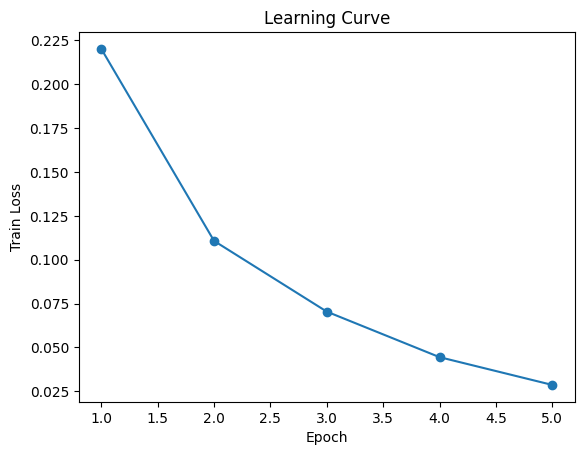

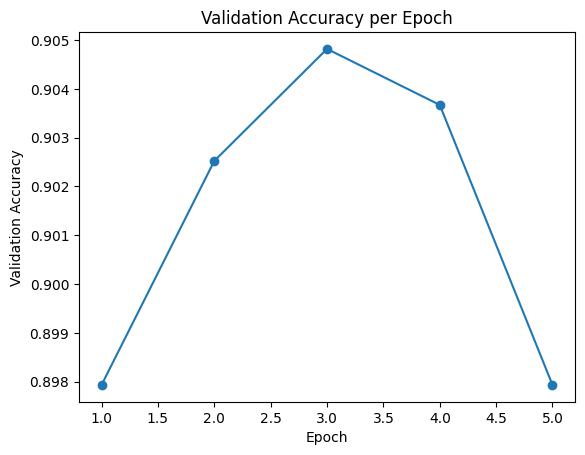

In [ ]:
train_losses = getattr(trainer.state, "custom_train_losses", [])
eval_accs    = getattr(trainer.state, "custom_eval_accs", [])
plt.figure(); plt.plot(range(1, len(train_losses)+1), train_losses, marker="o"); plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Learning Curve"); plt.show()
plt.figure(); plt.plot(range(1, len(eval_accs)+1), eval_accs, marker="o"); plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy"); plt.title("Validation Accuracy per Epoch"); plt.show()

In [ ]:
def run_model(backbone, epochs=5, lr=5e-5):
    seed_everything(5541)
    mod = AutoModelForSequenceClassification.from_pretrained(backbone, num_labels=2).to(device)
    arg = TrainingArguments(output_dir="./ckpts_"+backbone.split('/')[-1],
                          num_train_epochs=epochs, learning_rate=lr,
                          per_device_train_batch_size=32, per_device_eval_batch_size=64,
                          eval_strategy="epoch", logging_strategy="epoch",
                          save_strategy="no", report_to=[], seed=5541)
    CT = CustomTrainer(model=m, args=arg, train_dataset=encoded["train"],
                      eval_dataset=encoded["validation"], tokenizer=tokenizer, data_collator=data_collator)
    CT.train()
    return CT

In [ ]:
t_distil = run_model("distilbert-base-uncased") # smaller model used for comparison
t_bert   = run_model("bert-base-uncased")
print("DistilBERT val acc:", t_distil.state.custom_eval_accs[-1])
print("BERT-base  val acc:", t_bert.state.custom_eval_accs[-1])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3992993430.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  t = CustomTrainer(model=m, args=a, train_dataset=encoded["train"],


Epoch 01 | train_loss 0.2201 | val_loss 0.2975 | val_acc 0.8979
Epoch 02 | train_loss 0.1107 | val_loss 0.3675 | val_acc 0.9025
Epoch 03 | train_loss 0.0704 | val_loss 0.4126 | val_acc 0.9048
Epoch 04 | train_loss 0.0444 | val_loss 0.4204 | val_acc 0.9037
Epoch 05 | train_loss 0.0286 | val_loss 0.4751 | val_acc 0.8979
Time: 11.76 min


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3992993430.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  t = CustomTrainer(model=m, args=a, train_dataset=encoded["train"],


Epoch 01 | train_loss 0.2138 | val_loss 0.2725 | val_acc 0.9186
Epoch 02 | train_loss 0.1114 | val_loss 0.3874 | val_acc 0.9106
Epoch 03 | train_loss 0.0715 | val_loss 0.3975 | val_acc 0.9106
Epoch 04 | train_loss 0.0470 | val_loss 0.4232 | val_acc 0.9163
Epoch 05 | train_loss 0.0284 | val_loss 0.4715 | val_acc 0.9163
Time: 22.16 min
DistilBERT val acc: 0.8979358077049255
BERT-base  val acc: 0.9162843823432922


In [ ]:
import pandas as pd
import torch.nn.functional as F

def collect_errors(trainer, max_items=200):
    model = trainer.model.eval()
    dev   = trainer.args.device
    texts, golds, preds, confs = [], [], [], []
    with torch.no_grad():
        for batch in DataLoader(ds["validation"], batch_size=64, shuffle=False):
            enc = tokenizer(batch["sentence"], truncation=True, padding=True, return_tensors="pt").to(dev)
            logits = model(**enc).logits
            p = logits.argmax(1)
            prob = F.softmax(logits, dim=1).max(1).values
            texts.extend(batch["sentence"])
            golds.extend(batch["label"])
            preds.extend(p.cpu().tolist())
            confs.extend(prob.cpu().tolist())
    df = pd.DataFrame({
        "text": texts,
        "gold": [lbl_names[g] for g in golds],
        "pred": [lbl_names[p] for p in preds],
        "confidence": confs
    })
    df_err = df[df.gold != df.pred].head(max_items)
    return df, df_err

all_val, errors = collect_errors(t_distil, max_items=200)
print(len(errors), "errors collected")
errors.head(10)
errors.to_csv("sst2_val_errors.csv", index=False)

89 errors collected


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

llm_id = "Qwen/Qwen2.5-1.5B-Instruct"
llm_tok = AutoTokenizer.from_pretrained(llm_id)
llm     = AutoModelForCausalLM.from_pretrained(llm_id, device_map="auto", torch_dtype=torch.float16)

def llm_predict_label(text):
    prompt = (
        "Task: Given text, predict sentiment. Labels: Positive or Negative.\n"
        f"Text: {text}\n"
        "Label:"
    )
    inputs = llm_tok(prompt, return_tensors="pt").to(llm.device)
    out = llm.generate(**inputs, max_new_tokens=4)
    gen = llm_tok.decode(out[0], skip_special_tokens=True)
    # crude parse:
    gen = gen.split("Label:",1)[-1].strip().split()[0].lower()
    return "positive" if "pos" in gen else "negative"

# added LLM column to the first ~200 validation rows
sampled = all_val.sample(200, random_state=5541).copy()
sampled["llm_pred"] = sampled["text"].apply(llm_predict_label)
llm_acc = (sampled["llm_pred"] == sampled["gold"]).mean()
print("LLM (Qwen2.5-1.5B) acc on 200 val samples:", round(float(llm_acc), 4))
sampled.to_csv("sst2_val_with_llm.csv", index=False)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

LLM (Qwen2.5-1.5B) acc on 200 val samples: 0.92


In [ ]:
errors.head(10)

,text,gold,pred,confidence
20,pumpkin takes an admirable look at the hypocri...,negative,positive,0.909004
22,holden caulfield did it better .,negative,positive,0.992900
62,the primitive force of this film seems to bubb...,positive,negative,0.965055
82,it 's one pussy-ass world when even killer-thr...,negative,positive,0.818336
87,jaglom ... put ( s ) the audience in the privi...,positive,negative,0.996856
92,"you wo n't like roger , but you will quickly r...",negative,positive,0.999940
93,if steven soderbergh 's ` solaris ' is a failu...,positive,negative,0.999739
95,this riveting world war ii moral suspense stor...,negative,positive,0.999959
97,"no sophomore slump for director sam mendes , w...",positive,negative,0.983885
115,sam mendes has become valedictorian at the sch...,negative,positive,0.996436
